In [1]:
import tensorflow as tf
tf.config.set_visible_devices([], 'GPU')

2022-11-29 14:52:20.976768: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-29 14:52:21.926511: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/shimizu-reo/cudas/lib64:/usr/local/cuda/lib64:/usr/local/cuda/lib64:
2022-11-29 14:52:21.926624: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/shimizu-reo/cudas/lib64:/usr/local/cuda/l

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp

import neural_tangents as nt
from neural_tangents import stax

import tensorflow_datasets as tfds
import scipy as sp
from tqdm import tqdm

In [3]:
# Download MNIST
dataset_name = 'MNIST'
num_classes = 10
size = 32
name = 'mnist'
ds = tfds.load(name, split=tfds.Split.TRAIN).shuffle(1024, seed=42)

In [4]:
train_ds, test_ds = tfds.load('mnist:3.*.*', split=['train', 'test'])

def preprocess(x):
    image, label = x['image'], x['label']
    image = tf.cast(image, tf.float64)
    image = image / 255.
    image = tf.reshape(image, (-1,))
    return image, label

train_ds = train_ds.map(preprocess).as_numpy_iterator()
test_ds = test_ds.map(preprocess).as_numpy_iterator()

def load_x_y(ds):
    x_list, y_list = [], []
    for x, y in ds:
        x = x / np.linalg.norm(x)
        y = np.eye(num_classes)[y]
        x_list.append(x)
        y_list.append(y)
    return np.stack(x_list, axis=0), np.stack(y_list, axis=0)

train_x, train_y = load_x_y(train_ds)
test_x, test_y = load_x_y(test_ds)

In [5]:
train_x.shape, test_x.shape

((60000, 784), (10000, 784))

In [6]:
# gets experimental E_g(p)
def get_learning_curve(pvals, K, train_length, test_length, y_train, y_test, lamb=1e-8):
    pvals = [float(int(p)) for p in pvals]
    num_repeats = 50
    err = np.zeros((num_repeats, len(pvals), num_classes))
    for n in tqdm(range(num_repeats)):
        for i, p in enumerate(pvals):
            train_inds = np.random.randint(0, train_length, int(p))
            inds = np.concatenate([train_inds, np.arange(train_length, train_length + test_length)])
            K_train = K[train_inds, :][:, train_inds]
            K_new = K[train_inds, :][:, inds]
            y_hat = K_new.T @ jnp.linalg.inv(K_train + p*lamb*np.eye(int(p))) @ y_train[train_inds, :]
            y_gt = np.concatenate([y_train[train_inds], y_test], axis=0)
            class_inds = [[j for j in range(len(inds)) if y_gt[j, c]] for c in range(num_classes)]
            for c in range(len(class_inds)):
                err[n, i, c] += np.mean((y_hat[class_inds[c], :] - y_gt[class_inds[c], :])**2)
    return err.mean(axis=0), err.std(axis=0)

# implicit equation for kappa
def implicit_fn(z, *args):
    (p, lamb, spectrum) = args
    return z - lamb - z * np.dot(spectrum, (p*spectrum + z*np.ones(len(spectrum)) )**(-1))

# derivative of implicit function
def f_prime_true(z, *args):
    (p, lamb, spectrum) = args
    return 1 - np.dot(spectrum, (p*spectrum + z*np.ones(len(spectrum)) )**(-1)) + z* np.dot(spectrum, (p*spectrum + z*np.ones(len(spectrum)) )**(-2))

# solve implicit equation with Newton's method
def solve_implicit_z(spectrum, pvals, lamb):
    sols = np.zeros(len(pvals))
    for i, p in enumerate(pvals):
        args = (p, p*lamb, spectrum)
        sols[i] = sp.optimize.root_scalar(implicit_fn, x0 = p * lamb + p * np.amax(spectrum), args = args, fprime = f_prime_true, method = 'newton').root
    return sols

# compute theory learning curve E_g(p)
def compute_theory(pvals, spectrum, teacher, lamb):
    pvals = [float(int(p)) for p in pvals]
    errs = np.zeros((len(pvals), teacher.shape[1]))
    zvals = solve_implicit_z(spectrum, pvals, lamb)
    for i, p in tqdm(enumerate(pvals)):
        kappa = zvals[i]
        gamma = p * np.sum(spectrum ** 2 / (kappa + p * spectrum) ** 2)
        for j in range(teacher.shape[1]):
            errs[i, j] = kappa ** 2 / (1 - gamma) * np.sum(teacher[:, j] ** 2 / ((kappa + p * spectrum) ** 2))
    return errs / len(spectrum)

In [7]:
# define a RELU neural tangent kernel
_,_,kernel_fn = stax.serial(stax.Dense(1024), stax.Relu(), stax.Dense(num_classes))
kernel_fn = jax.jit(kernel_fn, static_argnums=(2,))

In [8]:
def exp_all_class(lamb=1e-8):

    pvals = np.logspace(0,4,16)

    np.random.seed(42)
    train_length = int(pvals[-1])
    test_length  = test_x.shape[0]
    train_inds = np.random.randint(0, train_x.shape[0], train_length)
    test_inds = np.random.randint(0, test_x.shape[0], test_length)

    y_train = train_y[train_inds, :]
    y_test = test_y[test_inds, :]

    all_x = np.concatenate([train_x[train_inds], test_x[test_inds]], axis=0)
    all_y = np.concatenate([y_train, y_test], axis=0)

    K = kernel_fn(all_x, all_x, 'ntk')
    lc, std = get_learning_curve(pvals, K, train_length, test_length, y_train, y_test, lamb)

    spectrum, vecs = jnp.linalg.eigh(1 / K.shape[0] * K)
    inds_sort = np.argsort(spectrum)
    inds_sort = inds_sort[::-1]
    spectrum = spectrum[inds_sort]
    vecs = vecs[:,inds_sort]

    # plot kernel eigenspectrum spectrum
    plt.loglog(spectrum)
    plt.xlabel(r'$\rho$', fontsize=20)
    plt.ylabel(r'$\lambda_\rho$', fontsize = 20)
    plt.show()

    # get target spectrum 
    teacher = vecs.T @ all_y
    theory_lc = compute_theory(pvals, spectrum, teacher, lamb)

    proj = vecs[:,0:3].T @ K

    for k,i in enumerate(range(10)):
        inds_i = [j for j in range(len(all_y)) if all_y[j, i] == 1]
        plt.scatter(proj[0,inds_i], proj[1,inds_i], s=0.15, color = 'C%d' % (k+7))
        plt.scatter([],[], color = 'C%d' % (k+7), label = '%d' % i)
    plt.xticks([])
    plt.yticks([])
    plt.xlabel('K-PC 1', fontsize=20)
    plt.ylabel('K-PC 2', fontsize = 20)
    plt.tight_layout()
    plt.legend()
    plt.show()
        

    power = (teacher ** 2)
    cumul = np.cumsum(power, axis=0) / np.sum(power, axis=0)
    print(cumul.shape)

    w, h = 4, 3
    plt.figure(figsize=(24, 16))
    for i in range(num_classes):
        plt.subplot(h, w, i+1)
        plt.semilogx(cumul[:, i])
        plt.title(f'{i}')
        plt.xlabel('k', fontsize = 12)
        plt.ylabel('C(k)', fontsize = 12)
    plt.subplot(h, w, num_classes+1)
    plt.semilogx(cumul.mean(axis=-1))
    plt.title(f'mean')
    plt.xlabel('k', fontsize = 12)
    plt.ylabel('C(k)', fontsize = 12)
    plt.show()

    plt.figure(figsize=(24, 16))
    for i in range(num_classes):
        plt.subplot(h, w, i+1)
        plt.errorbar(pvals, lc[:, i], std[:, i] , fmt = 'o', color='C0')
        plt.semilogx(pvals, theory_lc[:, i], '--', color='C0')
        plt.title(f'{i}')
        plt.xlabel(r'$P$', fontsize = 12)
        plt.ylabel(r'$E_g$', fontsize = 12)
    plt.subplot(h, w, num_classes + 1)
    plt.errorbar(pvals, lc.mean(axis=-1), std.mean(axis=-1) , fmt = 'o', color='C0')
    plt.semilogx(pvals, theory_lc.mean(axis=-1), '--', color='C0')
    plt.title(f'mean')
    plt.xlabel(r'$P$', fontsize = 12)
    plt.ylabel(r'$E_g$', fontsize = 12)
    plt.show()
    return (lc, std, theory_lc), (spectrum, vecs), proj, cumul, (all_x, all_y)

100%|██████████| 50/50 [16:12<00:00, 19.46s/it] 
/home/shimizu-reo/miniconda3/envs/jax/lib/python3.10/site-packages/jax/_src/numpy/lax_numpy.py:3463: UserWarning: 'kind' argument to argsort is ignored; only 'stable' sorts are supported.
  warnings.warn("'kind' argument to argsort is ignored; only 'stable' sorts "


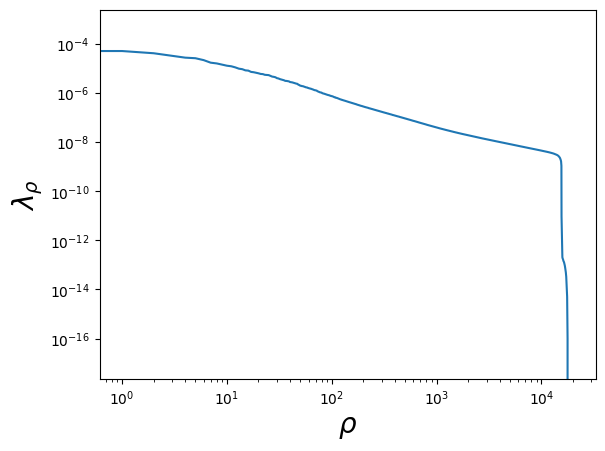

16it [00:00, 21.38it/s]


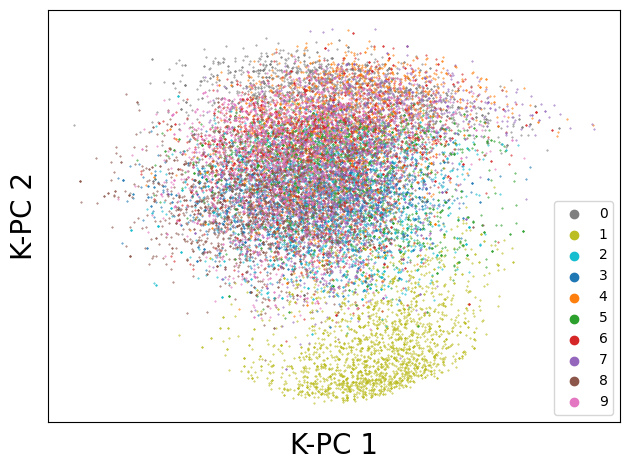

(20000, 10)


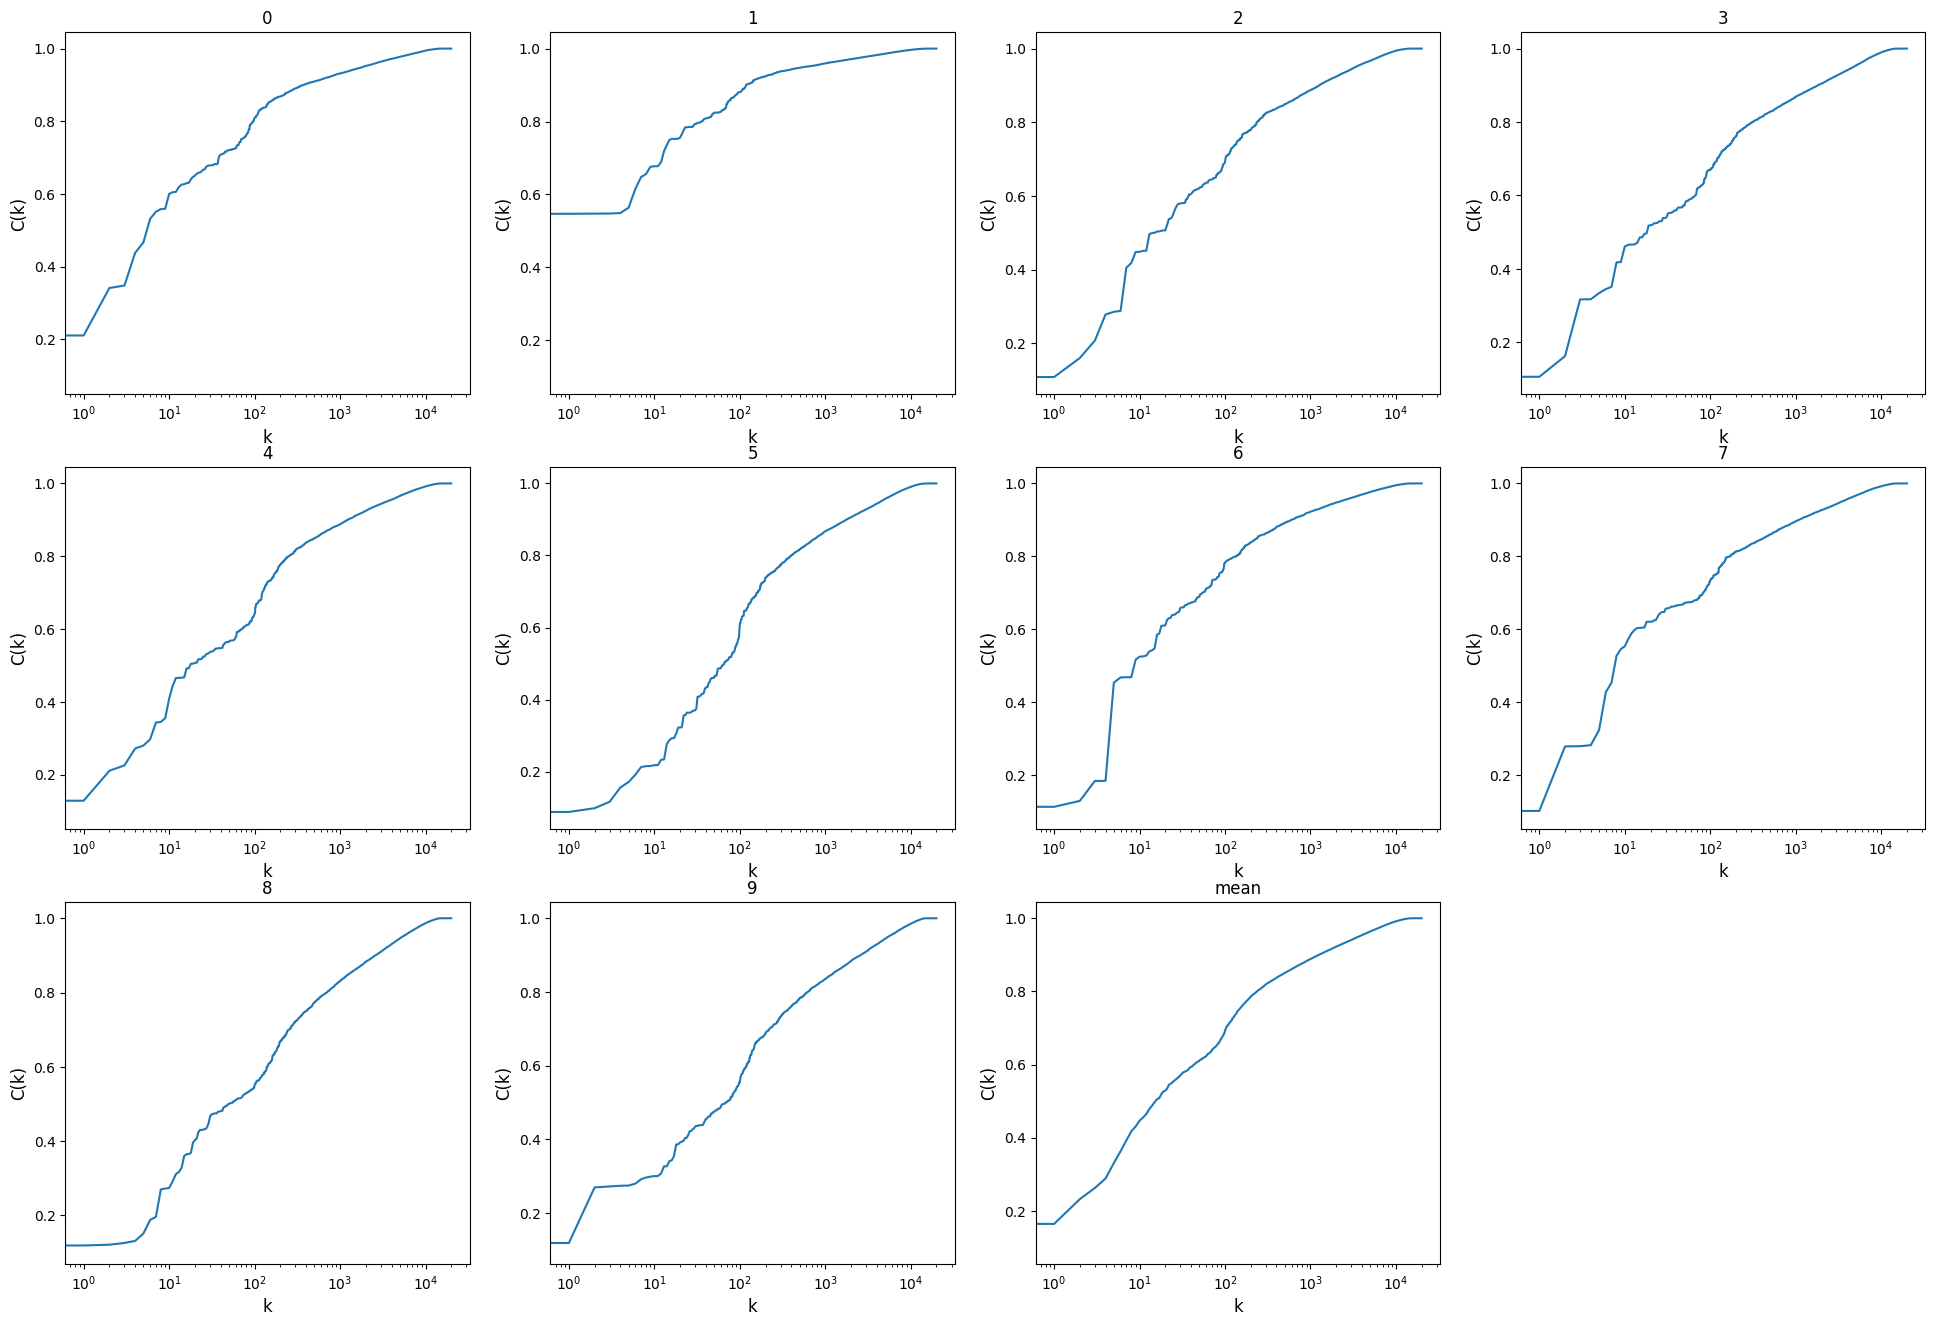

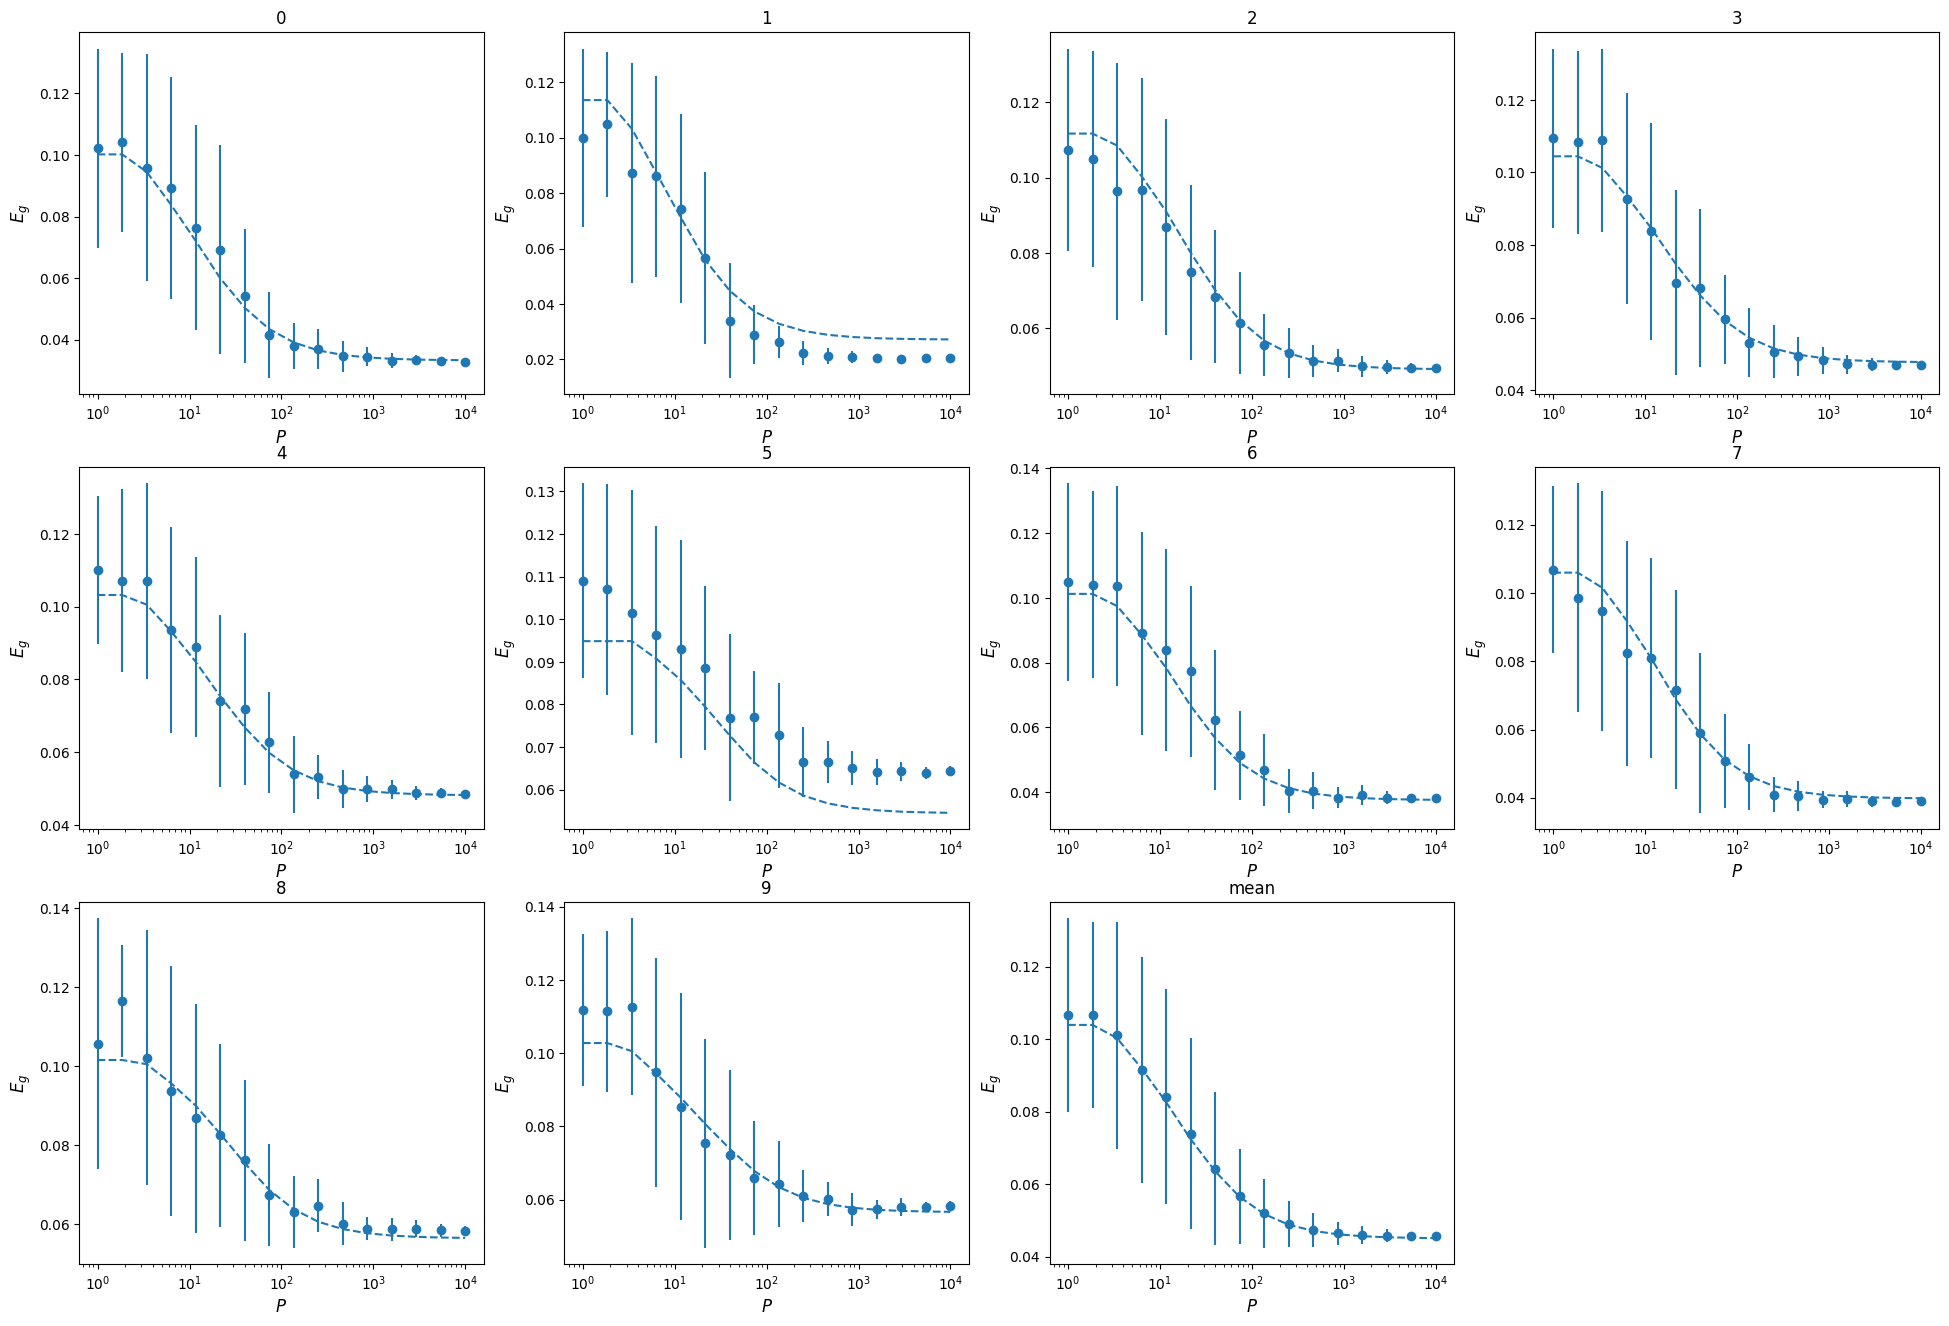

In [9]:
out = exp_all_class(lamb=1e-5)